In [1]:
import numpy as np
import gzip
import os
from sklearn import preprocessing, metrics
import pickle
from sklearn.model_selection import train_test_split
from typing import Tuple
from dataclasses import dataclass
import matplotlib.pyplot as plt
np.random.seed(1)

In [2]:
class MnistDataLoader:
    def __init__(self, data_folder_path):
        self.data_folder_path = data_folder_path
        self.train_file_name = 'train-images-idx3-ubyte.gz'
        self.train_label_file_name = 'train-labels-idx1-ubyte.gz'
        self.test_file_name = 't10k-images-idx3-ubyte.gz'
        self.test_label_file_name = 't10k-labels-idx1-ubyte.gz'
        self.data = dict()
        self.size = 28
        self.color_channel = 1
        self.data_list = [
            'train_images',
            'train_labels',
            'test_images',
            'test_labels'
        ]

    def load_images(self, data_list_index, file_name):
        images = gzip.open(os.path.join(self.data_folder_path, file_name), 'rb')
        self.data[self.data_list[data_list_index]] = np.frombuffer(images.read(), dtype=np.uint8, offset=16).reshape(-1, self.size, self.size)
        self.data[self.data_list[data_list_index]] = self.data[self.data_list[data_list_index]].reshape(self.data[self.data_list[data_list_index]].shape[0], self.size, self.size, self.color_channel).astype(np.float32)

    def load_labels(self, data_list_index, file_name):
        labels = gzip.open(os.path.join(self.data_folder_path, file_name), 'rb')
        self.data[self.data_list[data_list_index]] = np.frombuffer(labels.read(), dtype=np.uint8, offset=8)
        self.data[self.data_list[data_list_index]].resize(self.data[self.data_list[data_list_index]].shape[0],1)

    def load_mnist(self):
        self.load_images(data_list_index=0, file_name=self.train_file_name)
        self.load_labels(data_list_index=1, file_name=self.train_label_file_name)
        self.load_images(data_list_index=2, file_name=self.test_file_name)
        self.load_labels(data_list_index=3, file_name=self.test_label_file_name)

        self.assert_data_shape()

    def assert_data_shape(self):
        assert self.data[self.data_list[0]].shape == (60000, 28, 28, 1)
        assert self.data[self.data_list[1]].shape == (60000, 1)
        assert self.data[self.data_list[2]].shape == (10000, 28, 28, 1)
        assert self.data[self.data_list[3]].shape == (10000, 1)

    def preprocess_data(self):

        self.data[self.data_list[0]] /= 255
        self.data[self.data_list[2]] /= 255

        self.data[self.data_list[1]] = Utility.one_hot_encode(self.data[self.data_list[1]])
        self.data[self.data_list[3]] = Utility.one_hot_encode(self.data[self.data_list[3]])

        assert self.data[self.data_list[1]].shape == (60000, 10)

In [3]:
class Cifer10DataLoader:
    def __init__(self, data_path):
        self.data_path = data_path
        self.size = 32
        self.color_channel = 3
        self.per_batch_data_size = 10000
        self.data = dict()

    def load_data(self, file_name):
        with open(os.path.join(self.data_path, file_name), 'rb') as f:

            data_dict=pickle.load(f, encoding='latin1')

            images = data_dict['data']
            labels = data_dict['labels']

            images = images.reshape(self.per_batch_data_size, self.color_channel, self.size, self.size).transpose(0,2,3,1).astype("float")
            labels = np.array(labels)
            print(labels.shape)

            return images, labels

    def concatenate_data(self):
        X1, Y1 = self.load_data('data_batch_1')
        X2, Y2 = self.load_data('data_batch_2')
        X3, Y3 = self.load_data('data_batch_3')
        X4, Y4 = self.load_data('data_batch_4')
        X5, Y5 = self.load_data('data_batch_5')

        self.data['train_images'] = np.concatenate(
            (
                X1, X2, X3, X4, X5
            ),
            axis=0
        )

        self.data['train_labels'] = np.concatenate(
            (
                Y1.reshape(self.per_batch_data_size, 1),
                Y2.reshape(self.per_batch_data_size, 1),
                Y3.reshape(self.per_batch_data_size, 1),
                Y4.reshape(self.per_batch_data_size, 1),
                Y5.reshape(self.per_batch_data_size, 1)
            ),
            axis=0
        )

        X_test, Y_test = self.load_data('test_batch')

        self.data['test_images'] = X_test
        self.data['test_labels'] = Y_test.reshape(Y_test.shape[0], 1)

        self.assert_data_shape()

        for key, data in self.data.items():
            print(f'Shape: {data.shape}')

    def assert_data_shape(self):
        assert self.data['train_images'].shape == (50000, 32, 32, 3)
        assert self.data['train_labels'].shape == (50000, 1)
        assert self.data['test_images'].shape  == (10000, 32, 32, 3)
        assert self.data['test_labels'].shape  == (10000, 1)

    def preprocess_data(self):
        self.data['train_images'] /= 255
        self.data['test_images'] /= 255

        self.data['train_labels'] = Utility.one_hot_encode(self.data['train_labels'])
        self.data['test_labels'] = Utility.one_hot_encode(self.data['test_labels'])

        assert self.data['train_labels'].shape == (50000, 10)

## Convolution

In [34]:
class Convolution2D:

    # class variable
    layer_num = 1
    file_name = 'weights.txt'

    def __init__(self, num_out_channel, filter_size, stride, padding_size):
        self.num_out_channel = num_out_channel
        self.filter_size = filter_size
        self.stride = stride
        self.padding_size = padding_size
        self.h_prev, self.w_prev, self.num_channel_prev = None, None, None
        self.h_new, self.w_new = None, None
        self.W = None
        self.b = None
        self.output_tensor = None
        self.cache = {}
        self.layer_name = 'Conv2D__' + str(self.__class__.layer_num)
        self.__class__.layer_num += 1
        self.is_trainable = True
        self.training_mode = False
        self.activation_prev_current_layer_cache = None

        print('The layer name: ', self.layer_name, self.layer_num)

    def toggle_training_mode(self):
        if not self.training_mode:
            self.training_mode = True
        else:
            self.training_mode = False

    def initialize_output_dimensions(self, prev_layer_output_dim):
        """
        Initializes output dimensions with the dimension of the previous layers
        :param prev_layer_output_dim: output dimension of the layer immediately before this layer
        :return: None
        """
        self.h_prev, self.w_prev , self.num_channel_prev = prev_layer_output_dim
        self.h_new = (self.h_prev - self.filter_size + 2 * self.padding_size) // self.stride + 1
        self.w_new = (self.w_prev - self.filter_size + 2 * self.padding_size) // self.stride + 1

    def initialize_weights_biases(self):
        """
        Initializes weights with the proper dimensions
        :return:
        """
        #print('he: parameters: ', (self.h_prev * self.w_prev * self.num_channel_prev))
        self.W = np.random.randn(self.filter_size, self.filter_size, self.num_channel_prev, self.num_out_channel) * np.sqrt(2/(self.h_prev * self.w_prev * self.num_channel_prev))
        self.b = np.zeros((1, 1, 1, self.num_out_channel))

    def forward_wob(self, Z_prev, is_training):
        """
        Performs a forward operation of the convolution layer
        :param Z_prev: The activation of the previous layer
        :param is_training: whether we are in training mode or not
        :return:
        """

        assert Z_prev.shape == (self.h_prev, self.w_prev, self.num_channel_prev)
        Z_prev = np.array(Z_prev, copy=True)

        # create zero padded Z_prev
        Z_prev_padded = Utility.zero_pad_without_batch(Z_prev, self.padding_size)
        self.output_tensor = np.zeros((self.h_new, self.w_new, self.num_out_channel))

        # Apply convolution operation over this zero padded previous activation
        for row in range(self.h_new):

            row_start = row * self.stride

            for col in range(self.w_new):

                col_start = col *  self.stride

                for output_channel_index in range(self.num_out_channel):

                    Z_prev_windowed = Z_prev_padded[
                        row_start : row_start + self.filter_size,
                        col_start : col_start + self.filter_size,
                        :
                    ]

                    conv_step_W = self.W[:, :, :, output_channel_index]
                    conv_step_b = self.b[:, :, :, output_channel_index]

                    self.output_tensor[row, col, output_channel_index] = Utility.convolve_single_step(Z_prev_windowed, conv_step_W, conv_step_b)

        # asserting output shape
        assert(self.output_tensor.shape == (self.h_new, self.w_new, self.num_out_channel))

        if is_training:
            # cache some values
            pass

        # perform activation element wise in this case
        print(f'In forward of Convolution output tensor shape before relu {self.output_tensor.shape}')
        self.output_tensor = self.relu_activation.activation_f(self.output_tensor)

        # asserting output shape
        #assert(self.output_tensor.shape == (self.h_new, self.w_new, self.num_out_channel))
        print(f'In forward of CNN output tensor shape after relu {self.output_tensor.shape}')

    def forward_batch(self, Z_prev, is_training=True):
        """
        Performs a forward operation of the convolution layer
        :param Z_prev: The activation of the previous layer
        :param is_training: whether we are in training mode or not
        :return:
        """
        batch_size = Z_prev.shape[0]
        assert Z_prev.shape == (batch_size, self.h_prev, self.w_prev, self.num_channel_prev)

        self.output_tensor = np.zeros((batch_size, self.h_new, self.w_new, self.num_out_channel))
        Z_prev = np.array(Z_prev, copy=True)

        # create zero padded Z_prev
        print(f'Z prev shape:{Z_prev.shape}')
        Z_prev_padded = Utility.zero_pad(Z_prev, self.padding_size)

        # Apply convolution operation over this zero padded previous activation
        for image_index in range(batch_size):
            current_Z_prev_padded = Z_prev_padded[image_index] # choosing a single tensor from the batch
            for row in range(self.h_new):

                row_start = row * self.stride

                for col in range(self.w_new):

                    col_start = col *  self.stride

                    for output_channel_index in range(self.num_out_channel):

                        Z_prev_windowed = current_Z_prev_padded[
                                        row_start : row_start + self.filter_size,
                                        col_start : col_start + self.filter_size,
                                        :
                                        ]

                        conv_step_W = self.W[:, :, :, output_channel_index]
                        conv_step_b = self.b[:, :, :, output_channel_index]

                        self.output_tensor[image_index, row, col, output_channel_index] = Utility.convolve_single_step(Z_prev_windowed, conv_step_W, conv_step_b)

        # asserting output shape
        assert(self.output_tensor.shape == (batch_size, self.h_new, self.w_new, self.num_out_channel))
        print(self.output_tensor.shape)

        if is_training:
            # cache some values
            pass

        # perform activation element wise in this case
        #self.output_tensor = self.relu_activation.activation_f(self.output_tensor)

    def forward(self, Z_prev):
        """
        Performs a forward operation of the convolution layer
        :param Z_prev: The activation of the previous layer
        :param is_training: whether we are in training mode or not
        :return:
        """
        #print(Z_prev.shape)
        batch_size = Z_prev.shape[0]
        assert Z_prev.shape == (batch_size, self.h_prev, self.w_prev, self.num_channel_prev)

        self.output_tensor = np.zeros((batch_size, self.h_new, self.w_new, self.num_out_channel))

        # storing the activation for the bac propagation
        self.activation_prev_current_layer_cache = Z_prev

        Z_prev = np.array(Z_prev, copy=True)

        # create zero padded Z_prev
        #print(f'Z prev shape:{Z_prev.shape}')
        Z_prev_padded = Utility.zero_pad(Z_prev, self.padding_size)

        # Apply convolution operation over this zero padded previous activation
        for row in range(self.h_new):

            row_start = row * self.stride

            for col in range(self.w_new):

                col_start = col *  self.stride

                for output_channel_index in range(self.num_out_channel):

                    Z_prev_windowed = Z_prev_padded[:, row_start : row_start + self.filter_size,
                                            col_start : col_start + self.filter_size, :]

                    conv_step_W = self.W[:, :, :, output_channel_index]
                    conv_step_b = self.b[:, :, :, output_channel_index]

                    # print('z shape', Z_prev_windowed.shape)
                    # print('w shape', conv_step_W.shape)

                    # self.output_tensor[:, row, col, output_channel_index] = np.sum(
                    #     Z_prev_windowed * conv_step_W,
                    #     axis=(1,2,3)
                    # ) + conv_step_b

                    self.output_tensor[:, row, col, output_channel_index] = Utility.convolve_single_step_over_batch(
                        Z_prev_windowed, conv_step_W, conv_step_b
                    )

            # asserting output shape
            assert(self.output_tensor.shape == (batch_size, self.h_new, self.w_new, self.num_out_channel))
            #print('output tensor shape:', self.output_tensor.shape)

            if self.training_mode:
                # cache some values
                pass
            # # perform activation element wise in this case
            # self.output_tensor = self.relu_activation.activation_f(self.output_tensor)

    def forward_(self, Z_prev):
        """
        Performs a forward operation of the convolution layer
        :param Z_prev: The activation of the previous layer
        :param is_training: whether we are in training mode or not
        :return:
        """
        print(Z_prev.shape)
        batch_size = Z_prev.shape[0]
        assert Z_prev.shape == (batch_size, self.h_prev, self.w_prev, self.num_channel_prev)

        self.output_tensor = np.zeros((batch_size, self.h_new, self.w_new, self.num_out_channel))
        Z_prev = np.array(Z_prev, copy=True)

        # create zero padded Z_prev
        #print(f'Z prev shape:{Z_prev.shape}')
        Z_prev_padded = Utility.zero_pad(Z_prev, self.padding_size)

        # Apply convolution operation over this zero padded previous activation
        for row in range(self.h_new):

            row_start = row * self.stride

            for col in range(self.w_new):

                col_start = col *  self.stride

                Z_prev_windowed = Z_prev_padded[:,row_start : row_start + self.filter_size,
                                  col_start : col_start + self.filter_size,:, np.newaxis]

                conv_step_W = self.W[np.newaxis, :, :, :, :]
                conv_step_b = self.b[:, :, :, :]

                # print('z shape', Z_prev_windowed.shape)
                # print('w shape', conv_step_W.shape)

                # self.output_tensor[:, row, col, output_channel_index] = np.sum(
                #     Z_prev_windowed * conv_step_W,
                #     axis=(1,2,3)
                # ) + conv_step_b

                self.output_tensor[:, row, col, :] = Utility.convolve_single_step_over_batch(
                    Z_prev_windowed, conv_step_W, conv_step_b
                )

            # asserting output shape
            assert(self.output_tensor.shape == (batch_size, self.h_new, self.w_new, self.num_out_channel))
            #print('output tensor shape:', self.output_tensor.shape)

            if self.training_mode:
                # cache some values
                pass

            return self.output_tensor

            # # perform activation element wise in this case
            # self.output_tensor = self.relu_activation.activation_f(self.output_tensor)

    def get_output_tensor(self):
        return self.output_tensor

    def backward(self, dZ: np.array, learning_rate):
        mini_batch_size = dZ.shape[0]

        # initialize gradient shape
        dActivation_prev, dW, db = self.initialize_gradients(mini_batch_size=mini_batch_size)

        # do required padding
        activation_prev_padded = Utility.zero_pad(self.activation_prev_current_layer_cache, self.padding_size)
        dActivation_prev_padded = Utility.zero_pad(dActivation_prev, self.padding_size)

        for row in range(self.h_new):

            row_start = row * self.stride

            for col in range(self.w_new):

                col_start = col * self.stride

                for output_channel_index in range(self.num_out_channel):

                    # Use the corners to define the slice from a_prev_pad
                    activation_slice = activation_prev_padded[:, row_start:row_start + self.filter_size, col_start:col_start + self.filter_size, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    dActivation_prev_padded[:, row_start:row_start + self.filter_size, col_start:col_start + self.filter_size, :] += self.W[np.newaxis, :,:,:,output_channel_index] * dZ[: , row:row+1, col:col+1, np.newaxis,  output_channel_index] # done works

                    # print('a_slice:', a_slice.shape)
                    # print('dZ:', dZ[:, h:h+1, w:w+1, np.newaxis, c].shape)
                    # s = a_slice * dZ[:, h:h+1, w:w+1, np.newaxis, c]
                    # print('s shape:', s.shape)

                    dW[:,:,:,output_channel_index] += np.sum(activation_slice * dZ[:, row:row+1, col:col+1, np.newaxis, output_channel_index], axis=0)

                    db[:,:,:,output_channel_index] += np.sum(dZ[:, row:row+1, col:col+1, output_channel_index], axis=(0,1,2))

        # unpad the dActivation_padded
        if self.padding_size != 0:
            dActivation_prev[:, :, :, :] = dActivation_prev_padded[:,
                                       self.padding_size:-self.padding_size,
                                       self.padding_size:-self.padding_size,
                                       :]
        else:
            dActivation_prev = dActivation_prev_padded

        # careful here!!!
        dW = dW / mini_batch_size
        db = db / mini_batch_size

        assert dActivation_prev.shape == (mini_batch_size, self.h_prev, self.w_prev, self.num_channel_prev)

        assert dW.shape == (self.filter_size, self.filter_size, self.num_channel_prev, self.num_out_channel)

        assert db.shape == (1,1,1,self.num_out_channel)

        self.update_CNN_parameters(dW, db, learning_rate=learning_rate)

        #print('output of cnn backward:', dActivation_prev)
        #print('shape of output cnn backward: ', dActivation_prev.shape)
        return dActivation_prev

    def initialize_gradients(self, mini_batch_size):
        dActivation_prev = np.zeros((mini_batch_size, self.h_prev, self.w_prev, self.num_channel_prev))

        dW = np.zeros((self.filter_size, self.filter_size, self.num_channel_prev, self.num_out_channel))

        db = np.zeros((1,1,1, self.num_out_channel))

        return dActivation_prev, dW, db

    def update_CNN_parameters(self, dW : np.array, db: np.array, learning_rate: float):
        #print(f'learning rate: {learning_rate}')
        self.W = self.W - learning_rate * dW
        self.b = self.b - learning_rate * db

        # print('------------------ccccccccccccccccccccc----------------------------')
        # print(f'layer {self.layer_name} W updated: {self.W}')
        # print(f'layer {self.layer_name} b updated: {self.b}')

        f = open(self.file_name, 'a+')

        f.write(f'W of {self.layer_name} layer: \n')
        f.write(str(self.W))
        f.write("\n")

        f.write(f'b of {self.layer_name} layer: \n')
        f.write(str(self.b))
        f.write('\n')

        f.close()


    def print_layer_dimensions(self):
        print(f'Output Tensor Dimensions: {self.output_tensor.shape}')
        print(f'Weight Dimension: {self.W.shape}')
        print(f'Bias Dimension: {self.b.shape}')

    def get_output_dimension(self) -> Tuple:
        return self.h_new, self.w_new, self.num_out_channel

In [5]:
class Flatten:
    # class variable
    layer_num = 1

    def __init__(self):
        self.input_dim = None
        self.output_tensor = None
        self.output_dim = None
        self.h_prev, self.w_prev, self.num_channel_prev = None, None, None
        self.layer_name = 'Flatten__' + str(self.layer_num)
        self.__class__.layer_num += 1
        self.is_trainable = False
        self.shape_input_tensor = None

    def initialize_flatten_layer_dimensions(self, prev_layer_output_dim):
        """
        :param prev_layer_output_dim: prev layer output of shape (new_h, new_w, new_channel)
        :return: None
        """
        self.h_prev, self.w_prev, self.num_channel_prev  = prev_layer_output_dim
        self.output_dim = self.h_prev * self.w_prev * self.num_channel_prev

    def forward(self, Z_prev: np.array) -> np.array:
        """

        :param Z_prev: Z_prev of shape (1/batch size, prev_h, prev_w, prev_color_channel)
        :return: tensor of shape (1/batch size, prev_h * prev_w * prev_color_channel)
        """

        self.shape_input_tensor = Z_prev.shape
        self.output_tensor = Z_prev.reshape(Z_prev.shape[0], Z_prev.shape[1] * Z_prev.shape[2] * Z_prev.shape[3])

        assert self.output_tensor.shape[1] == self.output_dim

    def forward_wob(self, Z_prev: np.array) -> np.array:
        self.output_tensor = Z_prev.reshape(1, Z_prev.shape[0] * Z_prev.shape[1] * Z_prev.shape[2])

    def get_output_dimension(self):
        return self.output_dim

    def get_output_tensor(self) -> np.array:
        return self.output_tensor

    def backward(self, dZ: np.array):
        """

        :param dZ: dZ shape: (batch size/1, prev_h * prev_w * prev_color_channel)
        :return: tensor of shape: (batch size/1, prev_h, prev_w, prev_color_channel
        """

        assert dZ.shape == self.output_tensor.shape

        dZ_reshaped = dZ.reshape(self.shape_input_tensor)

        return dZ_reshaped


## MaxPool

In [6]:
class MaxPool:
    # class variable
    layer_num = 1

    def __init__(self, filter_size, stride):
        self.filter_size = filter_size
        self.stride = stride
        self.h_prev, self.w_prev, self.num_channel_prev = None, None, None
        self.h_new, self.w_new, self.num_out_channel = None, None, None
        self.output_tensor = None
        self.cache = {}
        self.layer_name = 'MaxPool__'+ str(self.layer_num)
        self.__class__.layer_num += 1
        self.is_trainable = False
        self.training_mode = False
        self.activation_prev_cached = None

    def toggle_training_mode(self):
        if not self.training_mode:
            self.training_mode = True
        else:
            self.training_mode = False

    def initialize_max_pool_params(self, prev_layer_output_dim):
        """
        Initializes output dimensions with the dimension of the previous layers
        :param prev_layer_output_dim: output dimension of the layer immediately before this layer
        :return: None
        """
        self.h_prev, self.w_prev , self.num_channel_prev = prev_layer_output_dim
        self.h_new = int((self.h_prev - self.filter_size) / self.stride + 1)
        self.w_new = int((self.w_prev - self.filter_size) / self.stride + 1)
        self.num_out_channel = self.num_channel_prev

    def forward_wob(self, Z_prev, is_training):

        #print('prev z shape in maxpool:', Z_prev.shape)
        assert Z_prev.shape == (self.h_prev, self.w_prev, self.num_channel_prev)
        #print('here')
        Z_prev = np.array(Z_prev, copy=True)
        #print('there')
        self.output_tensor = np.zeros((self.h_new, self.w_new, self.num_out_channel))

        #print('Going for max pooling')
        # Apply convolution operation over this zero padded previous activation
        for row in range(self.h_new):

            row_start = row * self.stride

            for col in range(self.w_new):

                col_start = col *  self.stride

                for output_channel_index in range(self.num_out_channel):

                    Z_prev_windowed = Z_prev[
                                      row_start : row_start + self.filter_size,
                                      col_start : col_start + self.filter_size,
                                      output_channel_index
                                      ]

                    self.output_tensor[row, col, output_channel_index] = Utility.get_max_pool_window(Z_prev_windowed)

        assert self.output_tensor.shape == (self.h_new, self.w_new, self.num_out_channel)
        if is_training:
            pass
        print('Max pool forward done')

    def forward(self, Z_prev):

        batch_size = Z_prev.shape[0]
        assert Z_prev.shape == (batch_size, self.h_prev, self.w_prev, self.num_channel_prev)

        self.activation_prev_cached = Z_prev

        self.output_tensor = np.zeros((batch_size, self.h_new, self.w_new, self.num_out_channel))
        Z_prev = np.array(Z_prev, copy=True)

        # Apply convolution operation over this zero padded previous activation
        for row in range(self.h_new):

            row_start = row * self.stride

            for col in range(self.w_new):

                col_start = col *  self.stride

                for output_channel_index in range(self.num_out_channel):

                    Z_prev_windowed = Z_prev[:,
                                    row_start : row_start + self.filter_size,
                                    col_start : col_start + self.filter_size,
                                    output_channel_index
                                      ]

                    self.output_tensor[:, row, col, output_channel_index] = Utility.get_max_pool_window_over_batch(Z_prev_windowed)

        assert self.output_tensor.shape == (batch_size, self.h_new, self.w_new, self.num_out_channel)
        if self.training_mode:
            pass

    def forward_(self, Z_prev):

        batch_size = Z_prev.shape[0]
        assert Z_prev.shape == (batch_size, self.h_prev, self.w_prev, self.num_channel_prev)
        self.activation_prev_cached = Z_prev

        self.output_tensor = np.zeros((batch_size, self.h_new, self.w_new, self.num_out_channel))
        Z_prev = np.array(Z_prev, copy=True)

        # Apply convolution operation over this zero padded previous activation
        for row in range(self.h_new):

            row_start = row * self.stride

            for col in range(self.w_new):

                col_start = col *  self.stride


                Z_prev_windowed = Z_prev[:,
                                    row_start : row_start + self.filter_size,
                                    col_start : col_start + self.filter_size,
                                      :
                                    ]

                self.output_tensor[:, row, col, :] = Utility.get_max_pool_window_over_batch(Z_prev_windowed)

        assert self.output_tensor.shape == (batch_size, self.h_new, self.w_new, self.num_out_channel)
        if self.training_mode:
            pass

    def print_layer_dimensions(self):
        print(f'Output Tensor Dimensions: {self.output_tensor.shape}')

    def get_output_tensor(self):
        return self.output_tensor

    # WOB
    def backward_(self, dActivation_pool: np.array):

        dActivation_pool_prev = np.zeros_like(self.activation_prev_cached)
        print(dActivation_pool_prev.shape)
        mini_batch_size = self.activation_prev_cached.shape[0]
        print('mini batch size:', mini_batch_size)

        for batch_index in range(mini_batch_size):
            # first select a fixed tensor from the batch
            activation_prev = self.activation_prev_cached[batch_index, :, :, :]

            # print('dA shape:', dA.shape)
            # print('h:', self.h_new)
            # print('w:', self.w_new)
            # print('c:', self.num_out_channel)

            for row in range(self.h_new):

                for col in range(self.w_new):

                    for output_channel_index in range(self.num_out_channel):

                        row_start = row * self.stride
                        row_end = row * self.stride + self.filter_size
                        col_start = col * self.stride
                        col_end = col * self.stride + self.filter_size

                        activation_prev_window = activation_prev[
                            row_start: row_end,
                            col_start: col_end,
                            output_channel_index
                        ]

                        # print('before the mask:', activation_prev_window)
                        mask = Utility.get_mask_from_tensor(activation_prev_window)
                        # print('the mashk:', mask)
                        # print(dActivation_pool.shape)
                        # print('batch index: ', batch_index)
                        # print('row: ', row)
                        # print('col: ', col)
                        # print('output channel index: ', output_channel_index)
                        # s = dActivation_pool[batch_index, row, col, output_channel_index]
                        dActivation_pool_prev[batch_index, row_start: row_end, col_start : col_end,output_channel_index] +=  dActivation_pool[batch_index, row, col, output_channel_index] * mask

                        #print(f'for batch {batch_index} {dActivation_pool_prev[batch_index,row: row + self.filter_size,col: col + self.filter_size,output_channel_index]}')

        # print(dActivation_pool.shape)
        #print(self.activation_prev_cached.shape)
        assert dActivation_pool_prev.shape == self.activation_prev_cached.shape
        print('-----------------------------------------------------------------------')
        print('Output of backward pooling non batched: ', dActivation_pool_prev)
        return dActivation_pool_prev

    # With Batching
    def backward(self, dActivation_pool: np.array):

        last_mask = None
        last_dA = None

        # print('sssssssssssssssssssssssssssssssssssssssssssss')
        # print('dA from previous:', dActivation_pool)
        # print()

        dActivation_pool_prev = np.zeros_like(self.activation_prev_cached)
        #print(self.activation_prev_cached.shape)
        mini_batch_size = self.activation_prev_cached.shape[0]
        #print('mini batch size:', mini_batch_size)

        for row in range(self.h_new):
            row_start = row * self.stride
            for col in range(self.w_new):
                col_start = col * self.stride
                for output_channel_index in range(self.num_out_channel):


                    activation_prev_window = self.activation_prev_cached[:, row_start: row_start + self.filter_size, col_start: col_start + self.filter_size, output_channel_index]
                    #print('before the mask:', activation_prev_window)
                    mask = Utility.get_mask_from_tensor_batch(activation_prev_window)
                    # last_mask = mask
                    # last_dA = dActivation_pool[:,  row: row + 1,  col: col + 1, output_channel_index]

                    dActivation_pool_prev[:, row_start: row_start + self.filter_size, col_start: col_start + self.filter_size, output_channel_index] += dActivation_pool[:,  row: row + 1,  col: col + 1, output_channel_index] * mask


        assert dActivation_pool_prev.shape == self.activation_prev_cached.shape
        # print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        # print('mask shape:', last_mask.shape)
        # print('the mask:', last_mask)
        #
        # print('the dA:', last_dA)
        # print('------------------------------------------------')
        # print('In pooling output custom:  -- dA', dActivation_pool_prev)
        return dActivation_pool_prev

    def get_output_dimension(self):
        return self.h_new, self.w_new, self.num_out_channel

## Denselayer

In [7]:
class DenseLayer:

    # class variable
    layer_num = 1
    file_name = './weights.txt'

    def __init__(self, num_units):
        self.W = None
        self.b = None
        self.dW = None
        self.db = None
        self.num_units = num_units
        self.A_prev_layer_cached = None
        self.output_tensor = None
        self.layer_name = 'Dense__' + str(self.__class__.layer_num)
        self.__class__.layer_num += 1
        self.is_trainable = True
        self.training_mode = False

    def toggle_training_mode(self):
        if not self.training_mode:
            self.training_mode = True
        else:
            self.training_mode = False


    def initialize_dense_layer_weights_biases(self, prev_layer_output_dim):
        self.W = np.random.randn(self.num_units, prev_layer_output_dim) * np.sqrt(2/prev_layer_output_dim)
        self.b = np.zeros((self.num_units, 1)) # will be broadcast to (hidden_units, batch_size) before addition

        #print('W dense: ', self.W)

    def forward(self, A_prev_layer):
        """
        :param A_prev_layer: tensor of shape (batch, prev_flattened_shape)
        :return:
        """

        # print('starting of dense: ', A_prev_layer)
        # print(f'A_prev_layer shape: {A_prev_layer.shape}')
        assert A_prev_layer.shape[1] == self.W.shape[1]

        self.A_prev_layer_cached = A_prev_layer

        A_prev_layer = np.array(A_prev_layer, copy=True)
        A_prev_layer_reshaped = A_prev_layer.T

        Z = np.dot(self.W, A_prev_layer_reshaped) + self.b

        self.output_tensor = Z.T # converting to (batch_size, num_units)
        #print('dense layer output: ',Z)

        # assert the output tensor shape should be (num_hidden_units, batch size)
        assert self.output_tensor.shape == (A_prev_layer_reshaped.shape[1], self.num_units)

        if self.training_mode:
            pass

    def get_output_tensor(self):
        return self.output_tensor

    def backward(self, dZ : np.array, learning_rate):
        """

        :param dZ: the gradient of loss with respect to this layers output Z. dZ = dL/dZ. Shape: (batch size , num_units)
        :return:
        """
        #
        # print('Start of dense backward: ', dZ)
        #print(learning_rate)

        # for softmax activation after this, the value of dZ = y_pred - y
        A_prev_layer = self.A_prev_layer_cached
        mini_batch_size = dZ.shape[0]
        dW = (1/mini_batch_size) * np.dot(dZ.T, A_prev_layer) # (num unit, 1) * (1, x) --> (num unit, x)
        db = (1/mini_batch_size) * np.sum(dZ.T, axis=1, keepdims=True)
        #dW =  np.dot(dZ.T, A_prev_layer) # (num unit, 1) * (1, x) --> (num unit, x)
        dA_prev_layer = np.dot(dZ, self.W)
        #db = np.sum(dZ.T, axis=1, keepdims=True)

        # print('dW', dW)
        # print('dB', db)

        #print(dW.shape)
        #print(db.shape)
        #print(self.b.shape)
        assert dW.shape == self.W.shape
        assert db.shape == self.b.shape
        assert dA_prev_layer.shape == A_prev_layer.shape

        self.update_parameters(dW, db, learning_rate=learning_rate)
        return dA_prev_layer

    def get_output_dimension(self):
        return self.num_units

    def print_layer_dimensions(self):
        print(f'Output Tensor Dimensions: {self.output_tensor.shape}')
        print(f'Weight Dimension: {self.W.shape}')
        print(f'Bias Dimension: {self.b.shape}')

    def update_parameters(self, dW: np.array, db: np.array, learning_rate: float):
        #print('updating parameters', learning_rate)
        self.W = self.W -   (dW * learning_rate)
        self.b = self.b -   (db * learning_rate)

        #print(f'Weight of {self.layer_name} : {self.W}')
        #print(f'Bias of {self.layer_name} : {self.b}')

        f = open(self.file_name, 'w+')

        f.write(f'W of {self.layer_name} layer: \n')
        f.write(str(self.W))
        f.write("\n")

        f.write(f'b of {self.layer_name} layer: \n')
        f.write(str(self.b))
        f.write('\n')

        f.close()


## Utility

In [32]:
class Utility:

    @staticmethod
    def one_hot_encode(y_true):
        # Define the One-hot Encoder
        ohe = preprocessing.OneHotEncoder()
        ohe.fit(y_true)
        y_true = ohe.transform(y_true).toarray()
        return y_true

    @staticmethod
    def zero_pad(tensor, pad_size):
        """
        :param tensor: tensor of shape (batch_size, h, w, num_channel)
        :return: padded tensor of shape (h + 2 * pad_size, w + 2 * pad_size, num_channel)
        """
        return np.pad(tensor, ((0,0), (pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='constant', constant_values=0)

    @staticmethod
    def zero_pad_without_batch(tensor, pad_size):
        """
        :param tensor: tensor of shape (h, w, num_channel)
        :return: padded tensor of shape (h + 2 * pad_size, w + 2 * pad_size, num_channel)
        """
        return np.pad(tensor, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='constant', constant_values=0)

    @staticmethod
    def convolve_single_step(Z_prev_windowed, W, b):
        """
        :param Z_prev_windowed: window of shape (F, F, num_channel_Z_prev)
        :param W: kernel/filter/weight of shape (F, F, num_channel_Z_prev)
        :param b: bias term of shape (1, 1, 1)
        :return: scaler convolved value
        """
        return np.multiply(Z_prev_windowed, W).sum() + float(b)

    @staticmethod
    def convolve_single_step_over_batch(tensor, W, b):
        # print('slice shape:', tensor.shape)
        # print('W shape:', W.shape)
        # print('b shape:', b.shape)
        return np.sum(tensor * W, axis=(1,2,3)) + b


    @staticmethod
    def get_max_pool_window(Z_prev_windowed):
        return Z_prev_windowed.max()

    @staticmethod
    def get_max_pool_window_over_batch(Z_prev_windowed: np.array):
        #print('In max pool', Z_prev_windowed.shape)
        #print(np.max(Z_prev_windowed, axis=(1,2)))
        return np.max(Z_prev_windowed, axis=(1,2))

    @staticmethod
    def create_mini_batches(X: np.array, Y: np.array, mini_batch_size: int):
        total_data = X.shape[0]
        for index in range(0, total_data, mini_batch_size):
            start_index = index
            end_index = min(start_index + mini_batch_size, total_data)
            yield X[start_index: end_index,...], Y[start_index: end_index, ...]

    @staticmethod
    def get_mask_from_tensor(tensor: np.array):
        mask = (tensor == np.max(tensor))
        return mask

    @staticmethod
    def get_mask_from_tensor_batch(tensor: np.array):
        mask = (tensor == tensor.max(axis=(1,2)).reshape(tensor.shape[0], 1, 1))
        return mask

    @staticmethod
    def read_model_config(file_path, data_loader):

        with open(file_path) as f:
            file_lines = [line.strip() for line in f.readlines()]
            print(file_lines)

            first_dense_layer_index = -1
            for index in range(len(file_lines)):
                if file_lines[index].startswith("FC") and not file_lines[index - 1].startswith("Flatten"):
                    first_dense_layer_index = index
                    break

            # print(first_dense_layer_index)

            if first_dense_layer_index != -1:
                file_lines.insert(first_dense_layer_index, 'Flatten')

            # print(file_lines)

            layer_list = [InputLayer(input_dimension=(data_loader.size, data_loader.size, data_loader.color_channel), is_trainable=False, layer_name='Input')]


            for line in file_lines:
                if line.startswith("Conv"):
                    line_splitted = line.split()
                    layer_list.append( Convolution2D(num_out_channel=int(line_splitted[1]), filter_size=int(line_splitted[2]), stride=int(line_splitted[3]), padding_size=int(line_splitted[4])))
                elif line.startswith("ReLU"):
                    layer_list.append(ReLUActivation())
                elif line.startswith("Pool"):
                    line_splitted = line.split()
                    layer_list.append(MaxPool(filter_size=int(line_splitted[1]), stride=int(line_splitted[2])))
                elif line.startswith("Flatten"):
                    layer_list.append(Flatten())
                elif line.startswith("FC"):
                    line_splitted = line.split()
                    layer_list.append(DenseLayer(int(line_splitted[1])))
                elif line.startswith("Softmax"):
                    layer_list.append(SoftmaxActivation())

            return layer_list





            # layer_list=[
            #     InputLayer(input_dimension=(mnist.size, mnist.size, mnist.color_channel), is_trainable=False, layer_name='Input'),
            #     Convolution2D(num_out_channel=6, filter_size=5, stride=1, padding_size=2),
            #     ReLUActivation(),
            #     MaxPool(filter_size=2, stride=2),
            #     Convolution2D(num_out_channel=12, filter_size=5, stride=1, padding_size=0),
            #     ReLUActivation(),
            #     MaxPool(filter_size=2, stride=2),
            #     Convolution2D(num_out_channel=100, filter_size=5, stride=1, padding_size=0),
            #     ReLUActivation(),
            #     Flatten(),
            #     DenseLayer(10),
            #     SoftmaxActivation()
            # ]

## ReLU

In [9]:
class ReLUActivation:

    # class variable
    layer_num = 1
    def __init__(self):
        self.layer_name = 'ReLU__' + str(self.layer_num)
        self.__class__.layer_num += 1
        self.input_tensor_dimension = None
        self.output_tensor = None
        self.is_trainable = False
        self.input_tensor_cached = None

    def set_input_tensor_dimension(self, prev_layer_tensor_dimension):
        self.input_tensor_dimension = prev_layer_tensor_dimension

    def forward(self, tensor):
        #print('Relu Input Tensor Shape: ', tensor.shape)
        # print('in relu:', tensor)
        # print('After: ', np.maximum(tensor, 0))
        self.input_tensor_cached = tensor
        self.output_tensor = np.maximum(tensor, 0)

    def get_output_dimension(self):
        return self.input_tensor_dimension


    def backward(self, dA: np.array):
        dA = np.array(dA, copy=True)
        dA[self.input_tensor_cached <= 0] = 0

        # print('In relu: dA', dA)
        return dA

In [10]:
@dataclass(unsafe_hash=True)
class InputLayer:
    """
    Class for saving input dimension
    """
    input_dimension: np.array
    is_trainable: bool
    layer_name: str

## Softmax

In [11]:
class SoftmaxActivation:

    # class variable
    layer_num = 1
    def __init__(self):
        self.input_tensor_dimension = None
        self.layer_name = 'Softmax__' + str(self.layer_num)
        self.__class__.layer_num += 1
        self.output_tensor = None
        self.is_trainable = False

    def set_input_tensor_dimension(self, prev_layer_tensor_dimension):
        self.input_tensor_dimension = prev_layer_tensor_dimension


    def forward(self, tensor):
        #print('softmax tensor shape:', tensor.shape) # expected tensor shape: (1/batch-size, classes)
        exponent = np.exp(tensor - np.max(tensor, axis=1, keepdims=True))

        #print('softmax exp shape',exponent.shape)
        summation_along_batch = np.sum(exponent, axis=1, keepdims=True)

        #print('softmax sum shape:', summation_along_batch.shape)

        self.output_tensor = exponent/summation_along_batch

        return self.output_tensor


    def get_output_dimension(self):
        return self.input_tensor_dimension

    @staticmethod
    def backward(dA: np.array):
        """ passes the backward gradient
        :param dA: the gradient wrt to the activation softmax
        :return:
        """
        return dA

In [12]:
class CrossEntropyLoss:
    epsilon = 1e-50

    def compute_cost(self, y_pred, y):
        mini_batch_size = y.shape[0]
        clipped_y_pred = np.clip(y_pred, self.epsilon, 1.0)
        cross_entropy_loss = -(1/mini_batch_size) * np.sum(np.multiply(y, np.log(clipped_y_pred)))
        return cross_entropy_loss

## Model Class

In [13]:
class Model:
    def __init__(self):
        self.layers = None # a list of layer object according to input
        self.layer_w_gradients = dict() # {'layer name': dw}
        self.layer_b_gradients = dict() # {'layer name': db}
        self.epochs = None
        self.cost_function = None
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'validation_loss': [],
            'validation_acc': []
        }

    def add(self, layer_list):
        self.layers = layer_list

    def initializer_layer_params(self):
        """
        This method initializes the layers in the model providing the input dimension that the layers expect to get
        :return: None
        """
        #InputLayer(input_dimension=input_dimension, is_trainable=False, layer_name='Input')

        assert self.layers[0].layer_name == 'Input'

        for previous_layer, current_layer in zip(self.layers, self.layers[1:]):
            prev_output_dim = None
            if previous_layer.layer_name == 'Input':
                prev_output_dim = previous_layer.input_dimension # H, W, Color Channel
            else:
                prev_output_dim = previous_layer.get_output_dimension()


            if current_layer.layer_name.startswith('Conv2D__'):
                current_layer.initialize_output_dimensions(prev_output_dim) # H, W, Color Channel
                current_layer.initialize_weights_biases()
            elif current_layer.layer_name.startswith('MaxPool__'):
                print(prev_output_dim)
                current_layer.initialize_max_pool_params(prev_output_dim) # H, W, Color Channel
            elif current_layer.layer_name.startswith('Dense__'):
                current_layer.initialize_dense_layer_weights_biases(prev_output_dim) # flatten layer dimension
            elif current_layer.layer_name.startswith('Flatten__'):
                current_layer.initialize_flatten_layer_dimensions(prev_output_dim) # (new_h, new_w, new_channel)
            elif current_layer.layer_name.startswith("ReLU") or current_layer.layer_name.startswith("Softmax") :
                current_layer.set_input_tensor_dimension(prev_output_dim) # for the activation layers


    def compile(self, cost_function):
        self.cost_function = cost_function

    def train(self, training_data, test_data, epochs=5, learning_rate=0.001, mini_batch_size=32):

        self.epochs = epochs
        X_test, Y_test = test_data
        # Split data into 50% train and 50% test subsets
        X_validation, X_test, Y_validation, Y_test = train_test_split(
            X_test, Y_test, test_size=0.5, shuffle=False, random_state=1
        )
        # print(X_validation.shape)
        # print(Y_validation.shape)
        # print(Y_validation[0:5])

        for e in range(epochs):
            # each epoch will run through a training once and update weights
            print(f'Running Epoch: {e+1}')
            X_train, Y_train = training_data
            total_data = X_train.shape[0]
            num_of_mini_batches = total_data//mini_batch_size


            # first we create the mini batches and then run training step through it
            i = 1
            batch_correct = 0
            train_loss = 0
            for X, Y in Utility.create_mini_batches(X=X_train, Y=Y_train, mini_batch_size=mini_batch_size):
                """
                X shape --> (mini_batch_size, h, w, color_channel)
                Y shape --> (mini_batch_size, num_of_class) (one hot encoded vector)
                """
                Y_pred = self.forward_propagation(X)
                # print('final input shape', Y_pred.shape)
                # print('final output:', Y_pred)
                y_pred_one_hot_encoded = Y_pred == Y_pred.max(axis=1).reshape(Y_pred.shape[0], 1)

                #print('Y_pred shape: {}')
                #print(metrics.classification_report(Y.argmax(axis=1), y_pred_one_hot_encoded.argmax(axis=1)))
                # batch_correct = np.sum(Y.argmax(axis=1) == y_pred_one_hot_encoded.argmax(axis=1))
                # batch_acc = batch_correct / mini_batch_size
                # print(f'Batch correct: {batch_correct} out of {mini_batch_size}')
                # print(f'Batch Acc: {batch_acc * 100} %')
                self.backward_propagation(Y_pred,Y, learning_rate, mini_batch_size)
                #train_loss = self.cost_function.compute_cost(Y_pred, Y)
                #print(f'Loss per batch: {train_loss * 100} %')
                print("\rProgress {:1.1%}".format(i / num_of_mini_batches), end="")
                i += 1

            print()
            self.calculate_metrics(X_train=X_train, Y_train=Y_train, X_validation=X_validation, Y_validation=Y_validation, epoch=e)

            # Y_train_pred_all = self.forward_propagation(X_train)
            # Y_train_pred_all_one_hot_encoded = Y_train_pred_all == Y_train_pred_all.max(axis=1).reshape(Y_train_pred_all.shape[0], 1)
            #
            # print(metrics.classification_report(Y_train.argmax(axis=1), Y_train_pred_all_one_hot_encoded.argmax(axis=1)))
            # print('macro f1 train set: ')
            # print(metrics.f1_score(Y_train.argmax(axis=1), Y_train_pred_all_one_hot_encoded.argmax(axis=1), average='macro'))
            #
            # train_loss = self.cost_function.compute_cost(Y_train_pred_all, Y_train)
            # print(f'Train Loss After a Epoch {e+1}: {train_loss * 100} %')
            # self.history['train_loss'].append((train_loss * 100))
            #
            # train_correct = np.sum(Y_train.argmax(axis=1) == Y_train_pred_all_one_hot_encoded.argmax(axis=1))
            # train_acc = train_correct / Y_train.shape[0]
            # print(f'Train Acc: {train_acc * 100} %')
            # self.history['train_acc'].append((train_acc * 100))
            #
            # # calculate validation accuracy and loss here
            # print('--------------Running On validation data-----------------')
            # Y_validation_pred = self.forward_propagation(X_validation)
            # Y__validation_pred_one_hot_encoded = Y_validation_pred == Y_validation_pred.max(axis=1).reshape(Y_validation_pred.shape[0], 1)
            #
            # print(metrics.classification_report(Y_validation.argmax(axis=1), Y__validation_pred_one_hot_encoded.argmax(axis=1)))
            # print('macro f1 validation set: ')
            # print(metrics.f1_score(Y_validation.argmax(axis=1), Y__validation_pred_one_hot_encoded.argmax(axis=1), average='macro'))
            #
            # validation_loss = self.cost_function.compute_cost(Y_validation_pred, Y_validation)
            # print(f'Validation Loss After a Epoch {e+1}: {validation_loss * 100} %')
            # self.history['validation_loss'].append((validation_loss * 100))
            #
            # val_correct = np.sum(Y_validation.argmax(axis=1) == Y__validation_pred_one_hot_encoded.argmax(axis=1))
            # val_acc = val_correct / Y_validation.shape[0]
            # print(f'Validation Acc: {val_acc * 100} %')
            # self.history['validation_acc'].append((val_acc * 100))

        print('Finished Training!')

        self.predict(X_test, Y_test)

    def predict(self, X_test, Y_test):
        print('--------------Running On testing data-----------------')
        Y_test_pred = self.forward_propagation(X_test)
        Y_test_pred_one_hot_encoded = (Y_test_pred == Y_test_pred.max(axis=1).reshape(Y_test_pred.shape[0], 1))

        print(metrics.classification_report(Y_test.argmax(axis=1), Y_test_pred_one_hot_encoded.argmax(axis=1)))
        print('macro f1 test set: ')
        print(metrics.f1_score(Y_test.argmax(axis=1), Y_test_pred_one_hot_encoded.argmax(axis=1), average='macro'))

        test_loss = self.cost_function.compute_cost(Y_test_pred, Y_test)
        print(f'Train Loss : {test_loss * 100} %')

        test_correct = np.sum(Y_test.argmax(axis=1) == Y_test_pred_one_hot_encoded.argmax(axis=1))
        test_acc = test_correct / Y_test.shape[0]
        print(f'Test Acc: {test_acc * 100} %')


    def forward_propagation(self, X_train) -> np.array:
        """
        Performs a forward pass through the network
        :param X_train: nd training tensor (batch_size, h, w, color_channel)
        :param is_training: whether we are training or not
        :return:
        """
        # print(f'In forward propagation: {self.layers[1].W}')

        input = X_train
        for layer in self.layers[1:]:
            # skipping the input layer
            #print(f'Forward for layer {layer.layer_name}')
            if not layer.layer_name.startswith('ReLU') and not layer.layer_name.startswith('Softmax') and not layer.layer_name.startswith('Flatten'):
                layer.toggle_training_mode() # toggling training mode for a layer
            layer.forward(input)
            input = layer.output_tensor # getting the output tensor of the layer to be the input tensor to the next
            #print(f'Output of layer {layer.layer_name}\n: {input}')

            if not layer.layer_name.startswith('ReLU') and not layer.layer_name.startswith('Softmax') and not layer.layer_name.startswith('Flatten'):
                layer.toggle_training_mode() # turning the training mode off here



        return input

    def backward_propagation(self, Y_out, Y, learning_rate, mini_batch_size):
        #print('here')

        # dA = (Y_out - Y) / mini_batch_size
        # print(f'In backpropagation: {self.layers[1].W}')
        dA = Y_out - Y
        #print('yhat - Y', dA)
        for layer in reversed(self.layers[1:]):
            #print(f'Running backward for layer {layer.layer_name}')
            if layer.is_trainable:
                dA = layer.backward(dA, learning_rate)
            else:
                dA = layer.backward(dA)


    def plot_metrics(self):
        epochs = range(0,self.epochs)
        plt.plot(epochs, self.history['train_acc'])
        plt.plot(epochs, self.history['validation_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(epochs, self.history['train_loss'])
        plt.plot(epochs, self.history['validation_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()


    def calculate_metrics(self, X_train, Y_train, X_validation, Y_validation, epoch):
        print('--------------Running On all training data-----------------')
        Y_train_pred_all = self.forward_propagation(X_train)
        Y_train_pred_all_one_hot_encoded = Y_train_pred_all == Y_train_pred_all.max(axis=1).reshape(Y_train_pred_all.shape[0], 1)

        print(metrics.classification_report(Y_train.argmax(axis=1), Y_train_pred_all_one_hot_encoded.argmax(axis=1)))
        print('macro f1 train set: ')
        print(metrics.f1_score(Y_train.argmax(axis=1), Y_train_pred_all_one_hot_encoded.argmax(axis=1), average='macro'))

        train_loss = self.cost_function.compute_cost(Y_train_pred_all, Y_train)
        print(f'Train Loss After a Epoch {epoch+1}: {train_loss * 100} %')
        self.history['train_loss'].append((train_loss * 100))

        train_correct = np.sum(Y_train.argmax(axis=1) == Y_train_pred_all_one_hot_encoded.argmax(axis=1))
        train_acc = train_correct / Y_train.shape[0]
        print(f'Train Acc: {train_acc * 100} %')
        self.history['train_acc'].append((train_acc * 100))

        # calculate validation accuracy and loss here
        print('--------------Running On validation data-----------------')
        Y_validation_pred = self.forward_propagation(X_validation)
        Y__validation_pred_one_hot_encoded = Y_validation_pred == Y_validation_pred.max(axis=1).reshape(Y_validation_pred.shape[0], 1)

        print(metrics.classification_report(Y_validation.argmax(axis=1), Y__validation_pred_one_hot_encoded.argmax(axis=1)))
        print('macro f1 validation set: ')
        print(metrics.f1_score(Y_validation.argmax(axis=1), Y__validation_pred_one_hot_encoded.argmax(axis=1), average='macro'))

        validation_loss = self.cost_function.compute_cost(Y_validation_pred, Y_validation)
        print(f'Validation Loss After a Epoch {epoch+1}: {validation_loss * 100} %')
        self.history['validation_loss'].append((validation_loss * 100))

        val_correct = np.sum(Y_validation.argmax(axis=1) == Y__validation_pred_one_hot_encoded.argmax(axis=1))
        val_acc = val_correct / Y_validation.shape[0]
        print(f'Validation Acc: {val_acc * 100} %')
        self.history['validation_acc'].append((val_acc * 100))


In [14]:
from sklearn import datasets, svm, metrics
a = np.random.randn(2,10)
print(a)
a_m = a.max(axis=1)
print('a_m', a_m)
a = a == a.max(axis=1).reshape(a.shape[0], 1)
v = a.argmax(axis=1)
np.sum(v == v)

[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944 -1.09989127
  -0.17242821 -0.87785842  0.04221375  0.58281521]]
a_m [1.74481176 1.46210794]


2

In [16]:
# np.random.seed(1)
# A_prev = np.random.randn(10,5,7,4) # h, w, c of previous layer
# cnn = Convolution2D(num_out_channel=8, filter_size=3, stride=2, padding_size=1)
# cnn.initialize_output_dimensions((A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]))
# cnn.initialize_weights_biases()
# #cnn.print_layer_dimensions()

In [17]:
# cnn.forward_(A_prev)

In [18]:
# print(cnn.output_tensor.shape)
# print("Z'as mean =\n", np.mean(cnn.output_tensor))
# print("Z[3,2,1] =\n", cnn.output_tensor[3,2,1])

In [19]:
# # Case 1: stride of 1
# np.random.seed(1)
# A_prev = np.random.randn(2, 5, 5, 3)
# maxpool = MaxPool(filter_size=3, stride=1)
# maxpool.initialize_max_pool_params((A_prev.shape[1],A_prev.shape[2],A_prev.shape[3]))
# maxpool.forward_(A_prev)
# maxpool.print_layer_dimensions()
# print(maxpool.output_tensor)

In [20]:
cifer_dataloader = Cifer10DataLoader('/home/akil/Work/Work/Academics/4-2/ML/Assignment-3/dataset/cifer-10/cifar-10-python/cifar-10-batches-py')
cifer_dataloader.concatenate_data()
cifer_dataloader.preprocess_data()
print(cifer_dataloader.data['train_images'].shape)
print(cifer_dataloader.data['train_labels'].shape)
# total_train_data = cifer_dataloader.data['train_images'].shape[0]
# mini_batch_size = 32
# p = np.random.permutation(total_data)
# cifer_dataloader.data['train_images'], cifer_dataloader.data['train_labels'] = cifer_dataloader.data['train_images'][p, :], cifer_dataloader.data['train_labels'][p, :]
X_train = cifer_dataloader.data['train_images']
Y_train = cifer_dataloader.data['train_labels']
X_test = cifer_dataloader.data['test_images']
Y_test = cifer_dataloader.data['test_labels']

(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
Shape: (50000, 32, 32, 3)
Shape: (50000, 1)
Shape: (10000, 32, 32, 3)
Shape: (10000, 1)
(50000, 32, 32, 3)
(50000, 10)


## Testing MNIST lr:0.02 e: 10

In [21]:
mnist = MnistDataLoader('./dataset/mnist')
mnist.load_mnist()
mnist.preprocess_data()

X_train = mnist.data[mnist.data_list[0]]
Y_train = mnist.data[mnist.data_list[1]]
X_test = mnist.data[mnist.data_list[2]]
Y_test = mnist.data[mnist.data_list[3]]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [22]:
np.random.seed(1)
cnn = Model()
cnn.add(Utility.read_model_config('./input.txt', mnist))
cnn.compile(cost_function=CrossEntropyLoss())
cnn.initializer_layer_params()

['Conv 6 5 1 2', 'ReLU', 'Pool 2 2', 'Conv 12 5 1 0', 'ReLU', 'Pool 2 2', 'Conv 100 5 1 0', 'ReLU', 'FC 10', 'Softmax']
The layer name:  Conv2D__1 2
The layer name:  Conv2D__2 3
The layer name:  Conv2D__3 4
(28, 28, 6)
(10, 10, 12)


In [23]:
cnn.train(training_data=(X_train, Y_train), epochs=10, learning_rate=0.02, test_data=(X_test, Y_test), mini_batch_size=32)

Running Epoch: 1
Progress 100.0%
--------------Running On all training data-----------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5923
           1       0.96      0.99      0.98      6742
           2       0.97      0.94      0.96      5958
           3       0.97      0.93      0.95      6131
           4       0.95      0.97      0.96      5842
           5       0.95      0.97      0.96      5421
           6       0.99      0.96      0.97      5918
           7       0.98      0.92      0.95      6265
           8       0.96      0.93      0.94      5851
           9       0.88      0.97      0.92      5949

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.96      0.96      0.96     60000

macro f1 train set: 
0.956380239822684
Train Loss After a Epoch 1: 13.821344086149576 %
Train Acc: 95.65166666666667 %
--------------Running On vali

In [36]:
16.99197735721404 / 100

0.1699197735721404

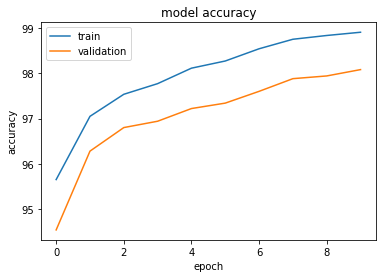

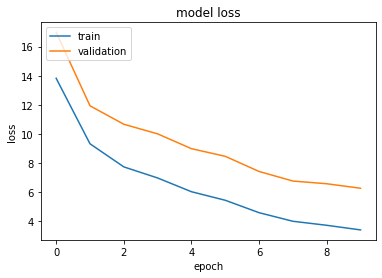

In [24]:
cnn.plot_metrics()

## Testing for cifer 10 data

In [25]:
cifer_dataloader = Cifer10DataLoader('/home/akil/Work/Work/Academics/4-2/ML/Assignment-3/dataset/cifer-10/cifar-10-python/cifar-10-batches-py')
cifer_dataloader.concatenate_data()
cifer_dataloader.preprocess_data()
print(cifer_dataloader.data['train_images'].shape)
X_train = cifer_dataloader.data['train_images']
Y_train = cifer_dataloader.data['train_labels']
X_test = cifer_dataloader.data['test_images']
Y_test = cifer_dataloader.data['test_labels']

(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
Shape: (50000, 32, 32, 3)
Shape: (50000, 1)
Shape: (10000, 32, 32, 3)
Shape: (10000, 1)
(50000, 32, 32, 3)
(50000, 10)


In [26]:
np.random.seed(1)
cnn = Model()
cnn.add(Utility.read_model_config('./input.txt', cifer_dataloader))
cnn.compile(cost_function=CrossEntropyLoss())
cnn.initializer_layer_params()

['Conv 6 5 1 2', 'ReLU', 'Pool 2 2', 'Conv 12 5 1 0', 'ReLU', 'Pool 2 2', 'Conv 100 5 1 0', 'ReLU', 'FC 10', 'Softmax']
The layer name:  Conv2D__4 5
The layer name:  Conv2D__5 6
The layer name:  Conv2D__6 7
(32, 32, 6)
(12, 12, 12)


In [27]:
cnn.train(training_data=(X_train, Y_train), epochs=10, learning_rate=0.02, test_data=(X_test, Y_test),mini_batch_size=32)

Running Epoch: 1
Progress 100.1%
--------------Running On all training data-----------------
              precision    recall  f1-score   support

           0       0.53      0.32      0.40      5000
           1       0.33      0.83      0.47      5000
           2       0.28      0.18      0.22      5000
           3       0.34      0.29      0.31      5000
           4       0.37      0.35      0.36      5000
           5       0.50      0.19      0.28      5000
           6       0.38      0.61      0.46      5000
           7       0.39      0.58      0.47      5000
           8       0.67      0.19      0.29      5000
           9       0.51      0.32      0.39      5000

    accuracy                           0.39     50000
   macro avg       0.43      0.39      0.37     50000
weighted avg       0.43      0.39      0.37     50000

macro f1 train set: 
0.36598784563920356
Train Loss After a Epoch 1: 167.39896270480165 %
Train Acc: 38.68 %
--------------Running On validation dat

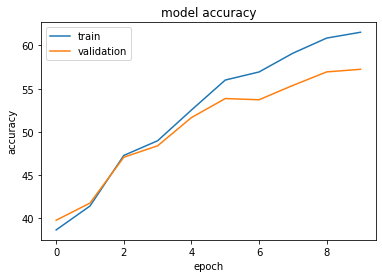

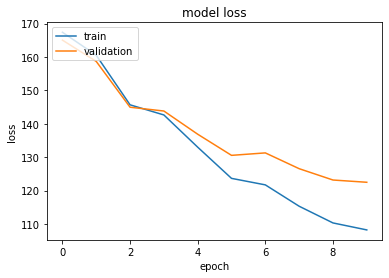

In [28]:
cnn.plot_metrics()

## Experiments

In [ ]:
dense = DenseLayer(num_units=4)
dense.W = np.array( [[ 1.4401747,   0.72498046, -0.05727674],
                     [-1.15246919, -0.39990891,  0.44136903],
                     [ 1.14171484, -1.41891945,  0.73059128],
                     [ 0.60664542, -0.08249916, -1.05893566]])
dense.W.shape

In [290]:
a = np.array([ [0.83351854,  -0.55429203,   0.0702855 ]])
a.shape

(1, 3)

In [291]:
dense.b = np.array( [[-0.64243089], [0.51146315], [-0.17120088], [1.10775354]])
dense.b.shape

(4, 1)

In [292]:
dense.forward(a)

A_prev_layer shape: (1, 3)


In [293]:
dz = dense.output_tensor
dense.backward(dz)

(4, 3)
(4, 1)
(4, 1)
[[ 0.12678218 -0.08431048  0.01069076]
 [-0.16374732  0.1088924  -0.01380781]
 [ 1.34887082 -0.89700266  0.11374199]
 [ 1.32088062 -0.8783891   0.11138175]]
[[ 0.15210481]
 [-0.19645312]
 [ 1.61828532]
 [ 1.58470455]]


In [294]:
s = np.array([[-0.39692968,  1.78981015, -0.54303206,  0.14530002,  1.42375341]])
s = s.reshape(1, -1)

In [295]:
soft = SoftmaxActivation()
print(soft.forward(s))

softmax tensor shape: (1, 5)
softmax exp shape (1, 5)
softmax sum shape: (1, 1)
[[0.05357302 0.47712828 0.0462908  0.09213688 0.33087103]]


In [315]:
np.random.seed(1)
X = np.random.randn(1,28,28,1)
Y = np.random.randn(1,10)
cnn = Model()
np.random.seed(1)

cnn = Model()
cnn.add(layer_list=[
    InputLayer(input_dimension=(mnist.size, mnist.size, mnist.color_channel), is_trainable=False, layer_name='Input'),
    Convolution2D(num_out_channel=6, filter_size=5, stride=1, padding_size=2),
    ReLUActivation(),
    MaxPool(filter_size=2, stride=2),
    Convolution2D(num_out_channel=12, filter_size=5, stride=1, padding_size=0),
    ReLUActivation(),
    MaxPool(filter_size=2, stride=2),
    Convolution2D(num_out_channel=100, filter_size=5, stride=1, padding_size=0),
    ReLUActivation(),
    Flatten(),
    DenseLayer(10),
    SoftmaxActivation()
])
cnn.compile(optimizer=GradientDescent(), cost_function=CrossEntropyLoss())
cnn.initializer_layer_params()

he: paramaters:  784
(28, 28, 6)
he: paramaters:  1176
(10, 10, 12)
he: paramaters:  300


In [314]:
cnn.train(training_data=(X, Y), validation_data=(None, None),mini_batch_size=1)

Running Epoch: 0
Forward for layer Conv2D__1
(1, 28, 28, 1)
Forward for layer ReLU__1
Relu Input Tensor Shape:  (1, 28, 28, 6)
Forward for layer MaxPool__1
Forward for layer Conv2D__1
(1, 14, 14, 6)
Forward for layer ReLU__1
Relu Input Tensor Shape:  (1, 10, 10, 12)
Forward for layer MaxPool__1
Forward for layer Conv2D__1
(1, 5, 5, 12)
Forward for layer ReLU__1
Relu Input Tensor Shape:  (1, 1, 1, 100)
Forward for layer Flatten__1
Forward for layer Dense__1
A_prev_layer shape: (1, 100)
Forward for layer Softmax__1
softmax tensor shape: (1, 10)
softmax exp shape (1, 10)
softmax sum shape: (1, 1)
final input shape (1, 10)
final output: [[0.09049115 0.06765897 0.1529529  0.08609433 0.04750961 0.10952845
  0.10272049 0.08826287 0.12400152 0.13077972]]
Loss is :  -6.485603025596568
Progress 100.0%

Cost After a Epoch 1: -648.5603025596567
Running Epoch: 1
Forward for layer Conv2D__1
(1, 28, 28, 1)
Forward for layer ReLU__1
Relu Input Tensor Shape:  (1, 28, 28, 6)
Forward for layer MaxPool__1

In [298]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward_(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

NameError: name 'conv_forward' is not defined

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3) # h, w, c of previous layer
cnn = Convolution2D(num_out_channel=8, filter_size=2, stride=2, padding_size=2)
cnn.initialize_output_dimensions((A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]))
cnn.initialize_weights_biases()
cnn.forward(A_prev)
Z = cnn.get_output_tensor()

In [ ]:
# Test conv_backward
dA, dW, db = cnn.backward(Z)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

In [ ]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
maxpool = MaxPool(filter_size=2, stride=1)
maxpool.initialize_max_pool_params((A_prev.shape[1],A_prev.shape[2],A_prev.shape[3]))
maxpool.forward(A_prev)
A = maxpool.get_output_tensor()
print('shape of A',A.shape)

dA = np.random.randn(5, 4, 2, 2)
print(dA[0,0,0,0])
out = maxpool.backward(dA)
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', out[1,1])
print()

In [ ]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
maxpool = MaxPool(filter_size=2, stride=1)
maxpool.initialize_max_pool_params((A_prev.shape[1],A_prev.shape[2],A_prev.shape[3]))
maxpool.forward(A_prev)
A = maxpool.get_output_tensor()
print('shape of A',A.shape)

dA = np.random.randn(5, 4, 2, 2)
print(dA[0,0,0,0])
out = maxpool.backward(dA)

print(out.shape)
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', out[1,1])
print()

In [35]:
np.random.seed(1)
cnn = Model()
cnn.add(Utility.read_model_config('./input.txt', cifer_dataloader))
cnn.compile(cost_function=CrossEntropyLoss())
cnn.initializer_layer_params()
cnn.train(training_data=(X_train, Y_train), epochs=10, learning_rate=0.02, test_data=(X_test, Y_test),mini_batch_size=32)

['Conv 6 5 1 2', 'ReLU', 'Pool 2 2', 'Conv 12 5 1 0', 'ReLU', 'Pool 2 2', 'Conv 100 5 1 0', 'ReLU', 'Conv 14 5 1 3', 'ReLU', 'FC 15', 'FC 10', 'Softmax']
Input
Conv2D__1
ReLU__19
MaxPool__11
Conv2D__2
ReLU__20
MaxPool__12
Conv2D__3
ReLU__21
Conv2D__4
ReLU__22
Flatten__6
Dense__9
Dense__10
Softmax__6
(32, 32, 6)
(12, 12, 12)
Running Epoch: 1
Progress 1.6%

KeyboardInterrupt: 